<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Ensembles and Random Forests
 
_Author: Joseph Nelson (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

## Learning Objectives

Students will be able to:

- Understand how and why decision trees can be improved using bagging and random forests.
- Build random forest models for classification and regression.
- Know how to extract the most important predictors in a random forest model.


## Lesson Guide
- [Introduction](#introduction)
- [ Manual Ensembling](#part-one)
- [Bagging](#part-two)
    - [Manually Implementing Bagged Decision Trees](#manual-bagged)
    - [Bagged Decision Trees in `scikit-learn`](#manual-sklearn)
    
    
- [ Random Forests](#part-three)
- [Building and Tuning Decision Trees and Random Forests](#part-four)
    - [Optional: Predicting Salary With a Decision Tree](#decision-tree)
    - [Predicting Salary With a Random Forest](#random-forest-demo)
    - [Comparing Random Forests With Decision Trees](#comparing)
    
    
- [Optional: Tuning Individual Parameters](#tuning)
- [Summary](#summary)

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

<a id="introduction"></a>
## Introduction

### What is Ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model. For example, given predictions from several models we could:

- **Regression:** Take the average of the predictions.
- **Classification:** Take a vote and use the most common prediction.

For ensembling to work well, the models must be:

- **Accurate:** They outperform the null model.
- **Independent:** Their predictions are generated using different processes.

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when you average the models.

There are two basic **methods for ensembling:**

- Manually ensembling your individual models.
- Using a model that ensembles for you.

<a id="part-one"></a>
## Manual Ensembling

What makes an effective manual ensemble?

- Different types of **models**.
- Different combinations of **features**.
- Different **tuning parameters**.

![Machine learning flowchart](assets/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*.

### Comparing Manual Ensembling With a Single Model Approach

**Advantages of manual ensembling:**

- It increases predictive accuracy.
- It's easy to get started.

**Disadvantages of manual ensembling:**

- It decreases interpretability.
- It takes longer to train.
- It takes longer to predict.
- It is more complex to automate and maintain.
- Small gains in accuracy may not be worth the added complexity.

<a id="part-two"></a>
## Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially because of **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general-purpose procedure for reducing the variance of a machine learning method but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

A **bootstrap sample** is a random sample with replacement. So, it has the same size as the original sample but might duplicate some of the original observations.

In [47]:
# Set a seed for reproducibility.
np.random.seed(1)

# Create an array of 1 through 20.
nums = np.arange(1, 21)
print(nums)

# Sample that array 20 times with replacement.
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**.
    - Take a vote for **classification trees**.

Notes:

- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

<a id="manual-bagged"></a>
## Manually Implementing Bagged Decision Trees (with B=10)

In [48]:
# Read in and prepare the vehicle training data.
import pandas as pd

path = './data/vehicles_train.csv'
train = pd.read_csv(path)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [49]:
# Set a seed for reproducibility.
np.random.seed(123)

# Create ten bootstrap samples (which will be used to select rows from the DataFrame).
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [50]:
# Show the rows for the first decision tree.
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [51]:
# Read in and prepare the vehicle testing data.
path = './data/vehicles_test.csv'
test = pd.read_csv(path)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [52]:
from sklearn.tree import DecisionTreeRegressor

# Grow each tree deep.
treereg = DecisionTreeRegressor(max_depth=None, random_state=124)

# List for storing predicted price from each tree:
predictions = []

# Define testing data.
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# Grow one tree for each bootstrap sample and make predictions on testing data.
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# Convert predictions from list to NumPy array.
predictions = np.array(predictions)
predictions

array([[ 1800.,  5000., 13000.],
       [ 1300.,  1300., 14000.],
       [ 2000.,  9000., 22000.],
       [ 4000.,  5000., 13000.],
       [ 1800.,  5000., 13000.],
       [ 5000.,  5000.,  4000.],
       [ 4000.,  9500., 13000.],
       [ 4000.,  5000., 14000.],
       [ 3000.,  5000., 14000.],
       [ 5000.,  5000.,  9500.]])

In [53]:
# Average predictions.
np.mean(predictions, axis=0)

array([ 3190.,  5480., 12950.])

In [54]:
# Calculate RMSE.
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

634.8228099241551

<a id="manual-sklearn"></a>
## Bagged Decision Trees in `scikit-learn` (with B=500)

In [55]:
# Define the training and testing sets.
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [56]:
# Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator."
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, bootstrap=True, 
                          oob_score=True, random_state=1)

In [57]:
# Fit and predict.
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3604.,  5192., 12790.])

In [58]:
# Calculate RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

739.7702345999061

### Estimating Feature Importance

Bagging increases **predictive accuracy** but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** Calculate the total amount that **MSE** decreases due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** Calculate the total amount that **Gini index** decreases due to splits over a given feature, averaged over all trees

<a id="part-three"></a>
## Random Forests

Random Forests offer a **slight variation on bagged trees** with even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **random forests "decorrelate" the trees** to the extent that the averaging process can reduce the variance of the resulting model.
- Another way of looking at it is that sometimes one or two strong features dominate every tree in bagging, resulting in essentially the same tree as every predictor. (This is what was meant when saying the trees could be highly correlated.) By using a subset of features to generate each tree, we get a wider variety of predictive trees that do not all use the same dominant features.

<a id="part-four"></a>
## Part 4: Building and Tuning Decision Trees and Random Forests

In this section, we will implement random forests in scikit-learn.

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player.
- **Goal:** Predict player salary.

### Preparing the Data

In [59]:
# Read in the data.
path ='./data/hitters.csv'
hitters = pd.read_csv(path)

# Remove rows with missing values.
hitters.dropna(inplace=True)

In [60]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [61]:
# Encode categorical variables as integers.
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [62]:
# Allow plots to appear in the notebook.
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\asiminovsky\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


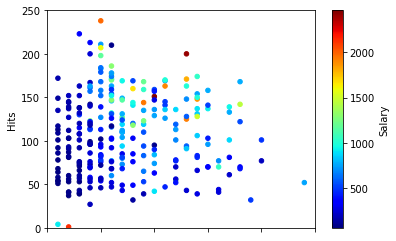

In [63]:
# Create a scatter plot of hits vs years, colored by salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250));

In [64]:
# Define features: Exclude career statistics (which start with "C") and the response (salary).
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [65]:
# Define X and y.
X = hitters[feature_cols]
y = hitters.Salary

<a id="decision-tree"></a>
## Optional: Predicting Salary With a Decision Tree

Let's first recall how we might predict salary using a single decision tree.

We'll first find the best **max_depth** for a decision tree using cross-validation:

In [66]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

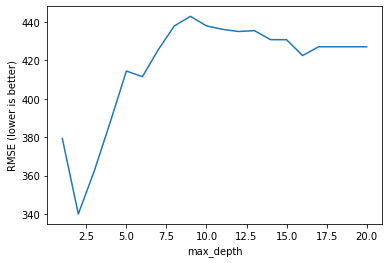

In [67]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [68]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.034168704752, 2)

In [69]:
# max_depth=2 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [70]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,Hits,0.511609
6,Years,0.488391
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000


<a id="random-forest-demo"></a>
## Predicting Salary With a Random Forest

### Fitting a Random Forest With the Best Parameters

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(max_features=5, n_estimators=150, random_state=1)

In [73]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
12,NewLeague,0.004000
7,League,0.004439
8,Division,0.008536
10,Assists,0.028667
11,Errors,0.036901
2,HmRun,0.041608
9,PutOuts,0.062130
3,Runs,0.079611
0,AtBat,0.093446
4,RBI,0.133207


In [74]:
# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

295.47994138792376

#### Reducing X to its Most Important Features

In [79]:
# Check the shape of X.
X.shape

(263, 13)

** It important not to select features before separating your train from your test otherwise you are selecting features based on all known observations and introducing more of the information in the test data to the model when you fit it on the training data. **

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 89)

In [81]:
# Fit the model on only the train data
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=150, oob_score=True,
                      random_state=1)

In [82]:
# Set a threshold for which features to include.
from sklearn.feature_selection import SelectFromModel

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

(197, 5)
(197, 7)


Using the fit model and the features from the train data to transform the test data

In [83]:
# Create a new feature matrix that only includes important features.

X_important =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)

In [84]:
X_important

array([[510, 147,  52,  53,   7],
       [419, 101,  58,  92,  20],
       [475, 126,  43,  52,   6],
       [453, 101,  43,  61,   3],
       [155,  41,  29,  22,  16],
       [627, 177,  81,  70,   6],
       [539, 139,  58,  69,   5],
       [475, 123,  93,  72,   4],
       [283,  77,  47,  26,  16],
       [568, 158,  75,  73,  15],
       [522, 163,  46,  62,  13],
       [522, 140,  77,  60,   4],
       [380, 120,  51,  31,   8],
       [416, 113,  69,  16,   1],
       [424, 110,  47,  36,   7],
       [208,  57,  25,  18,   3],
       [537, 147,  88,  47,  10],
       [581, 145,  68,  21,   2],
       [416, 132,  49,  33,   3],
       [370,  96,  46,  60,  15],
       [479, 133,  72,  55,  17],
       [593, 152,  75,  53,   6],
       [279,  69,  31,  32,   4],
       [633, 210,  56,  59,   6],
       [627, 178,  76,  46,   6],
       [560, 161,  96,  66,   4],
       [323,  81,  32,   8,   2],
       [280,  82,  45,  47,   2],
       [256,  70,  36,  44,  16],
       [547, 1

In [85]:
# Check the RMSE for a random forest that only includes important features.
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

314.39051968316204

# Using Random Forest for Classification

In [89]:
from sklearn.ensemble import RandomForestClassifier

X = hitters[['HmRun']]
y= hitters.League

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 89)

rfreg = RandomForestClassifier(n_estimators=150, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=1)

In [90]:
y_pred = rfreg.predict(X_test)

In [92]:
# true negative, false positive, false negative, true positive
tn, fp, fn, tp = metrics.confusion_matrix(y_true= y_test, y_pred = y_pred).ravel()

# accuracy score
print(rfreg.score(X_test, y_test))

print(tn)
print(fp)
print(fn)
print(tp)

# not very accurate -- consider adding features to X to increase accuracy

0.5303030303030303
15
19
12
20


<a id="comparing"></a>
## Comparing Random Forests With Decision Trees

**Advantages of random forests:**

- Their performance is competitive with the best supervised learning methods.
- They provide a more reliable estimate of feature importance.
- They allow you to estimate out-of-sample error without using train/test split or cross-validation.

**Disadvantages of random forests:**

- They are less interpretable.
- They are slower to train.
- They are slower to predict.

![Machine learning flowchart](assets/driver_ensembling.png)

*Machine learning flowchart created by the [second-place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*.

<a id="tuning"></a>
## Optional: Tuning Individual Parameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which represents the number of trees that should be grown. This should be a large enough value that the error seems to have "stabilized."

In [ ]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

_** In theory, the RMSE will continue to decrease and eventually level out.  Adding more estimators will neither (noticably)increase or decrease the RMSE (or other loss metric). However, introduction of noise can lead to random spikes as the n_estimators changes. This example is particularly interesting as after about 120 estimators the RMSE seems to steadily rise as more estimators are added.**_

### Tuning max_features

The other important tuning parameter is **max_features**, which represents the number of features that should be considered at each split.

In [ ]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [ ]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

<a id="summary"></a>
## Summary

**Which model is best?** The best classifier for a particular task is task-dependent. In many business cases, interpretability is more important than accuracy. So, decision trees may be preferred. In other cases, accuracy on unseen data might be paramount, in which case random forests would likely be better (since they typically overfit less). 

Remember that every model is a tradeoff between bias and variance. Ensemble models attempt to reduce overfitting by reducing variance but increasing bias (as compared to decision trees). By making the model more stable, we necessarily make it fit the training data less accurately. In some cases this is desired (particularly if we start with lots of overfitting), but for more simply structured data a simple decision tree might be best.

---

**In this lesson:**

- We looked at ensemble models.

- We saw how decision trees could be extended using two ensemble techniques -- bagging and random forests.

- We looked at methods of evaluating feature importance and tuning parameters.